# 15 LoopStack

In [1]:
# default_exp loopstack

In [2]:
# export
from forgebox.loop import Loop,ProgressBar,Tolerate,Event,Stuff,chunkify
from types import MethodType
import numpy as np

To run through iterations quickly, we use the california housing data

In [3]:
from sklearn.datasets.california_housing import fetch_california_housing
x,y = fetch_california_housing(return_X_y = True)

x.shape, y.shape

((20640, 8), (20640,))

Normalized Data

Preview x input

In [4]:
def norm(m,s): return lambda x: (x-m)/s
def denorm(m,s): return lambda x: (x*s)+m

x_normed = norm(x.mean(0),x.std(0))(x)
y_normed = norm(y.mean(),y.std())(y)

In [5]:
x_normed.mean(0).astype(np.float16),x_normed.std(0),\
y_normed.mean().astype(np.float16),y_normed.std()

(array([ 0.,  0.,  0., -0., -0.,  0., -0., -0.], dtype=float16),
 array([1., 1., 1., 1., 1., 1., 1., 1.]),
 0.0,
 1.0)

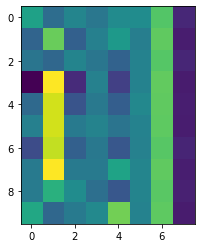

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(x_normed[np.random.choice(range(1000),10)])

In [7]:
x_normed

array([[ 2.34476576,  0.98214266,  0.62855945, ..., -0.04959654,
         1.05254828, -1.32783522],
       [ 2.33223796, -0.60701891,  0.32704136, ..., -0.09251223,
         1.04318455, -1.32284391],
       [ 1.7826994 ,  1.85618152,  1.15562047, ..., -0.02584253,
         1.03850269, -1.33282653],
       ...,
       [-1.14259331, -0.92485123, -0.09031802, ..., -0.0717345 ,
         1.77823747, -0.8237132 ],
       [-1.05458292, -0.84539315, -0.04021111, ..., -0.09122515,
         1.77823747, -0.87362627],
       [-0.78012947, -1.00430931, -0.07044252, ..., -0.04368215,
         1.75014627, -0.83369581]])

In [8]:
# export
def create_event(event_name):
    class BatchEvent(Event):pass
    BatchEvent.__name__ = event_name
    return BatchEvent

def events(*enames):
    return list(map(create_event,enames))

In [9]:
# export
class LoopStack(Loop):
    settings = []
    """
    A stack of loop
    """
    @classmethod
    def from_loops(cls,*loops):
        def init(self,iterable=[],name = None):
            name = name if name!=None else cls.__name__
            
            self.loops = dict()
            l = Loop(iterable)
            for L in loops:
                l = L(iterable = l)
            super().__init__(iterable = l,
                             name = name)
            
            for stuff in cls.settings:
                self.make_stuff(stuff)
            
        setattr(cls,"init",init)
        return cls
    
    @classmethod
    def new_setting(cls,*settings):
        cls.settings+=list(settings)
    
    def make_stuff(self,name):
        new_stuff = Stuff(name)
        setattr(self.core,name,new_stuff)
        setattr(self,name,new_stuff)
    
    def __repr__(self,):
        return f"LoopStack>:{self.name}\n\t"+\
            "\n\t".join(map(str,self.core.layers[:-1]))

In [10]:
TRAIN_EVENTS = ["DATA_PROCESS","FORWARD","LOSS_CALC",
                "BACKWARD","OPT_STEP","METRICS"]
EVAL_EVENTS = ["DATA_PROCESS","EVAL_WRAP","FORWARD","LOSS_CALC","METRICS"]

In [72]:
# export 
import torch

def train_callbacks(loop):
    @loop.on_DATA_PROCESS
    def opt_zero_grad(loop):
        loop.opt("zero_grad")
        
    @loop.before_1st_FORWARD
    def switch_model_to_train(loop):
        loop.model("train")
        
    @loop.BACKWARD.on
    def opt_step(loop):
        loop.loss("backward")
            
    @loop.BACKWARD.on
    def opt_step(loop):
        loop.opt("step")
        
def to_tensor(x):
    return torch.Tensor(x)
        
def train_single_forward(metric_func = []):
    def train_single_forward_cb(loop):
        @loop.on_DATA_PROCESS
        def set_xy(loop):
            loop.x["x1"],loop.y["y1"] = loop.element
            loop.x.update(to_tensor)
            loop.y.update(to_tensor)
            
        @loop.on_FORWARD
        def forward_pass(loop):
            loop.core.pred = loop.model("__call__",loop.x.x1)[0]
            
        @loop.on_LOSS_CALC
        def calculate_loss(loop):
            loop.loss["latest"] = loop.loss_func("__call__",loop.pred,loop.y.y1)
            
        @loop.on_METRICS
        def calcualte_metrics(loop):
            # calculate metrics
            with torch.no_grad():
                for func in metric_func:
                    loop.metric[func.__name__] = func(loop.pred,loop.y)
                    
            # loop through metrics
            loop.pgbar_data(loop.metric.cases)
            
    return train_single_forward_cb
    
class TrainLoop(LoopStack):
    def __init__(self,data_iter,model=[],opt=[],loss_func=[],loss=[],hp=[],cuda=[], 
                 callbacks = [train_callbacks,],tolerate=True):
        loops = [ProgressBar,]
        if tolerate:
            loops.append(Tolerate)
        loops+=list(events(*TRAIN_EVENTS))
        self.from_loops(*loops)
        self.new_setting("model","x","y",
                         "opt","loss_func","loss",
                         "hp","cuda","metric_func","metric")
        self.init(data_iter,)
        for cb in callbacks:
            print(f"assigning callback {cb}")
            cb(self)
        
class EvalLoop(LoopStack):
    def __init__(self,data_iter,tolerate=True):
        loops = [ProgressBar,]
        if tolerate:
            loops.append(Tolerate)
        loops+=list(events(*EVAL_EVENTS))
        self.from_loops(*loops)
        self.new_setting("model","opt","loss","hp","cuda")
        self.__init__(data_iter,)
        
        @self.EVAL_FORWARD.downstream
        def torch_eval_wrap(self,func):
            with torch.no_grad():
                func()

In [73]:
from torch import nn
loop = TrainLoop(list(zip(chunkify(x_normed),chunkify(y_normed))),
                 tolerate=False,
                 callbacks=[train_callbacks,train_single_forward([nn.MSELoss()])])
loop

assigning callback <function train_callbacks at 0x1a28d47950>
assigning callback <function train_single_forward.<locals>.train_single_forward_cb at 0x1a28d5c5f0>


LoopStack>:TrainLoop
	layer🍰Loop
	layer🍰ProgressBar
	event🌏DATA_PROCESS
	event🌏FORWARD
	event🌏LOSS_CALC
	event🌏BACKWARD
	event🌏OPT_STEP
	event🌏METRICS

In [74]:
loop.search()

interactive(children=(Text(value='', description='KeyWord'), Output()), _dom_classes=('widget-interact',))

In [75]:
loop.summary()

Loop layer TrainLoop summary:
🍰layer0.0	layer🍰Loop
--------------------------------------------------
🍰layer1.0	layer🍰ProgressBar
	[🐍func_name]	pgbar_data
	[⛰doc]	
        update progress bar with python dictionary
        data: python dictionary
        
	[😝var]	self,data
	[😜names]	t,set_postfix
	...................................
	[🐍func_name]	pgbar_description
	[⛰doc]	
        update progress bar prefix with text string
        
	[😝var]	self,text
	[😜names]	t,set_description_str
	...................................
--------------------------------------------------
🍰layer2.0	event🌏DATA_PROCESS
	[🐍func_name]	after_last_DATA_PROCESS
	[⛰doc]	
            Append new after_last callback for event:DATA_PROCESS
            Use this function as decorator
        
	[😝var]	cls,f
	[😜names]	getattr
	...................................
	[🐍func_name]	before_1st_DATA_PROCESS
	[⛰doc]	
            Append new before_1st callback for event:DATA_PROCESS
            Use this function as decorator
      

In [76]:
from torch import nn

In [77]:
loop.model["baseline"] = torch.nn.Linear(8,1)

In [78]:
# loop.loss_func["mse"] = torch.nn.MSELoss()
# loop.metric_func["loss"]= torch.nn.MSELoss()

In [79]:
loop.run()

AttributeError: 'list' object has no attribute 'backward'

In [80]:
loop.model

🍄:model[
	baseline
]

In [67]:
loop.loss_func

🍄:loss_func[
	
]

In [47]:
type(loop.x.x1)

torch.Tensor

In [48]:
loop.metric

🍄:metric[
	
]

In [49]:
def get_error(e):
    """
    String format error massage and trace back
    """
    import sys,traceback
    from io import StringIO
    exc_type, exc_value, exc_traceback = sys.exc_info()
    sio = StringIO()
    traceback.print_exception(exc_type, exc_value, exc_traceback,
                              limit=100, file=sio)
    return sio.getvalue()

e = loop.error_list()[0]["error"]
get_error(e)

'NoneType: None\n'

In [50]:
e

IndexError('list index out of range')

In [71]:
loop.pred,loop.y.y1

(tensor([[ 0.7769],
         [ 0.2967],
         [ 0.6991],
         [ 0.6803],
         [ 0.3590],
         [ 0.5273],
         [ 0.4915],
         [ 0.3569],
         [-0.0015],
         [ 0.4416],
         [ 0.3151],
         [ 0.3791],
         [ 0.3341],
         [ 0.4002],
         [ 0.2497],
         [ 0.2458],
         [ 0.2327],
         [ 0.3615],
         [ 0.0947],
         [ 0.2408],
         [-0.1149],
         [ 0.0087],
         [ 0.0926],
         [ 0.2175],
         [ 0.2622],
         [ 0.1142],
         [ 0.2609],
         [ 0.1703],
         [ 0.1444],
         [ 0.2212],
         [ 0.0442],
         [ 0.1634]], grad_fn=<AddmmBackward>),
 tensor([ 2.1296,  1.3142,  1.2587,  1.1651,  1.1729,  0.5446,  0.8003,  0.2994,
          0.1720,  0.4701,  0.6469,  0.3028,  0.0576, -0.1348, -0.4130, -0.5794,
         -0.4711, -0.4451, -0.4173, -0.3809, -0.5144, -0.4078, -0.8056, -0.9286,
         -0.6435, -0.8610, -0.9797, -0.8784, -0.8489, -0.6487, -0.7328, -0.7943]))